In [59]:
from datetime import date as Date, timedelta
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [340]:
url = 'https://coronavirus.data.gov.uk/downloads/{data_type}/coronavirus-cases_latest.{data_type}'
base = '~/Downloads'
area = 'Area name'
date = 'Specimen date'
cases = 'Daily lab-confirmed cases'

lockdown = Date(2020, 3, 23)
testing = Date(2020, 4, 30)
relax_1 = Date(2020, 5, 11)

brighton = 'E06000043'
west_sussex = 'E10000032'
east_sussex = 'E10000011'
areas = [brighton, west_sussex, east_sussex]

hammersmith = 'E09000013'
kensington = 'E09000020'
ealing = 'E09000009'
hounslow = 'E09000018'
richmond = 'E09000027'
wandsworth = 'E09000032'
brent = 'E09000005'
areas = [hammersmith, kensington, ealing, hounslow, richmond, wandsworth, brent]

wirral = 'E08000015'
cheshire = 'E06000050'
liverpool = 'E08000012'
sefton = 'E08000014'
knowsley = 'E08000011'
st_helens = 'E08000013'
areas = [wirral, cheshire, liverpool, sefton, knowsley, st_helens]

bristol = 'E06000023'
south_gloucestershire = 'E06000025'
bath = 'E06000022'
north_somerset = 'E06000024'
areas = [bristol, south_gloucestershire, bath, north_somerset]

hampshire = 'E10000014'
areas = [hampshire]

bedford = 'E06000055'
central_bedfordshire = 'E06000056'
areas = [bedford, central_bedfordshire]

northampton = 'E10000021'
milton_keynes =  'E06000042'
bedford = 'E06000055'

areas = [northampton, milton_keynes, bedford]

wokingham = 'E06000041'
reading = 'E06000038'
west_berks = 'E06000037'
bracknell = 'E06000036'
oxfordshire = 'E10000025'
areas = [wokingham, reading, west_berks, bracknell]

# areas = [oxfordshire]

force_download = False
#for_date = Date.today()-timedelta(days=1)
for_date = Date.today()

In [341]:
for suffix in 'csv', 'json':
    path = Path(base).expanduser() / f'coronavirus-cases_{for_date}.{suffix}'
    if force_download or not path.exists():
        response = requests.get(url.format(data_type=suffix))
        assert response.status_code==200
        with path.open('wb') as target:
            target.write(response.content)

In [342]:
def data_for_date(dt, areas):
    df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{dt}.csv')
    by_area = df[df['Area type'].str.startswith('Upper') & df['Area code'].isin(areas)]
    data = by_area[[date, area, cases]].pivot_table(values=cases, index=[date], columns=area).fillna(0)
    labels = pd.date_range(start=data.index.min(), end=data.index.max())
    return data.reindex([str(date.date()) for date in labels], fill_value=0)

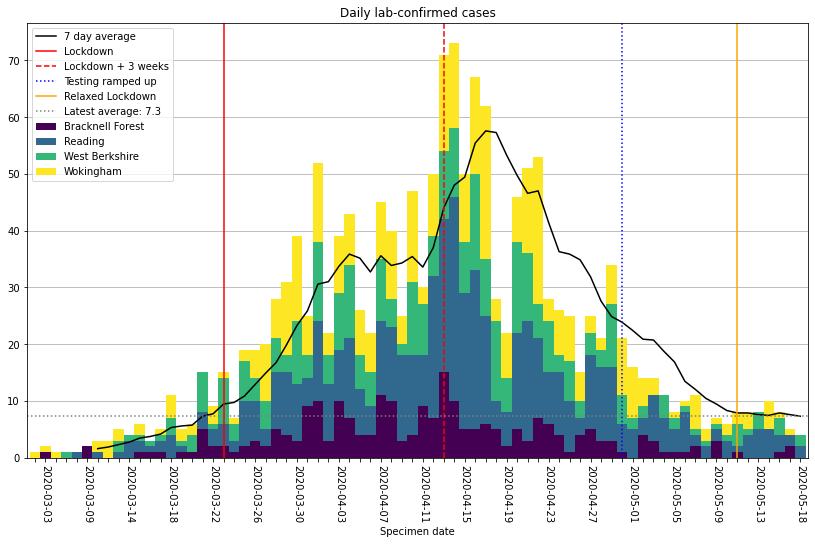

In [222]:
data = data_for_date(for_date, areas)
ax = data.plot(
    kind='bar', stacked=True, figsize=(14, 8), width=1, rot=-90, colormap='viridis',
    title=cases, legend=False
)
mean = data.sum(axis=1).rolling(7).mean()
mean.plot(ax=ax, color='k', label='7 day average', rot=-90)

labels = ax.xaxis.get_ticklabels()
for i, label in enumerate(reversed(labels)):
    if i%4:
        label.set_text('')
ax.axes.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.set_ticklabels(labels)

plt.axvline(x=data.index.get_loc(str(lockdown)), color='r', linestyle='-', label='Lockdown')
plt.axvline(x=data.index.get_loc(str(lockdown+timedelta(days=21))), color='r', linestyle='--', label='Lockdown + 3 weeks')
plt.axvline(x=data.index.get_loc(str(testing)), color='b', linestyle=':', label='Testing ramped up')
plt.axvline(x=data.index.get_loc(str(relax_1)), color='orange', linestyle='-', label='Relaxed Lockdown')

plt.axhline(y=mean.iloc[-1], color='grey', linestyle=':', label=f'Latest average: {mean.iloc[-1]:.1f}')

plt.legend()  
plt.show()

In [223]:
previous_data = data_for_date(for_date-timedelta(days=1), areas)

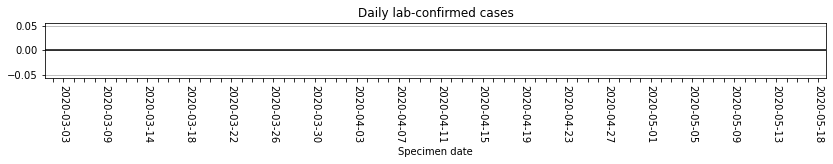

In [224]:
labels = pd.date_range(start=min(previous_data.index.min(), data.index.min()),
              end=max(previous_data.index.max(), data.index.max()))

diff = data.sub(previous_data, fill_value=0).reindex([str(date.date()) for date in labels], fill_value=0)

ax = diff.plot(
    kind='bar', stacked=True, figsize=(14, 1), width=1, rot=-90, colormap='viridis',
    title=cases, legend=False
)

labels = ax.xaxis.get_ticklabels()
for i, label in enumerate(reversed(labels)):
    if i%4:
        label.set_text('')
ax.axes.set_axisbelow(True)
ax.yaxis.grid(True)
loc = plticker.MultipleLocator(base=1.0)
ax.yaxis.set_major_locator(loc)
ax.xaxis.set_ticklabels(labels)
plt.axhline(y=0, color='k')
plt.show()